In [1]:
import emoji
import nltk
import numpy as np
import os
import pandas as pd
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer as ps
from nltk.tokenize import word_tokenize, sent_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from stop_words import get_stop_words
from textblob import TextBlob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
%matplotlib inline

denial = ['нельзя']
stopwords_russian = list(set(get_stop_words("ru") + 
                             stopwords.words('russian') +
                             ['а','у', 'о', '☕', '♡','♥', 'б', 'аж', 'л', 'ха', 'х'
                              '❤', '❤️','❤️', '❤️', '�','✌️', 'd', '❤',
                              'dd', 'p' 'rt', 'щ', 'з', 'эй', 'ибо', '❄️']).difference(denial))

max_words = 2000
max_len = 23
num_classes = 1

morph_analyz = MorphAnalyzer()
punkts = set(string.punctuation)
nltk.download('punkt')

#Training
epochs = 10
batch_size = 512
print_batch_n = 100

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
len(stopwords_russian)

441

In [4]:
stopwords_russian.sort()

In [5]:
stopwords_russian

['d',
 'dd',
 'prt',
 'а',
 'аж',
 'алло',
 'б',
 'без',
 'близко',
 'более',
 'больше',
 'будем',
 'будет',
 'будете',
 'будешь',
 'будто',
 'буду',
 'будут',
 'будь',
 'бы',
 'бывает',
 'бывь',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'важная',
 'важное',
 'важные',
 'важный',
 'вам',
 'вами',
 'вас',
 'ваш',
 'ваша',
 'ваше',
 'ваши',
 'вверх',
 'вдали',
 'вдруг',
 'ведь',
 'везде',
 'весь',
 'вниз',
 'внизу',
 'во',
 'вокруг',
 'вон',
 'восемнадцатый',
 'восемнадцать',
 'восемь',
 'восьмой',
 'вот',
 'впрочем',
 'времени',
 'время',
 'все',
 'всегда',
 'всего',
 'всем',
 'всеми',
 'всему',
 'всех',
 'всею',
 'всю',
 'всюду',
 'вся',
 'всё',
 'второй',
 'вы',
 'г',
 'где',
 'говорил',
 'говорит',
 'год',
 'года',
 'году',
 'да',
 'давно',
 'даже',
 'далеко',
 'дальше',
 'даром',
 'два',
 'двадцатый',
 'двадцать',
 'две',
 'двенадцатый',
 'двенадцать',
 'двух',
 'девятнадцатый',
 'девятнадцать',
 'девятый',
 'девять',
 'действительно',
 'дел',
 'день',
 'десятый',
 'десять'

In [6]:
torch.cuda.is_available()

True

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Data load

In [8]:
DATA_ROOT = 'D:/Data/Study/twitter_sentiment_analysis_via_RNN_GRU_LSTM/'

In [9]:
df_train = pd.read_csv(DATA_ROOT + 'train.csv')
df_val = pd.read_csv(DATA_ROOT + 'val.csv')
df_test = pd.read_csv(DATA_ROOT + 'test.csv')

In [10]:
df_train.head(5)

id                                               text  class
0   0  @alisachachka не уезжаааааааай. :(❤ я тоже не ...      0
1   1  RT @GalyginVadim: Ребята и девчата!\nВсе в кин...      1
2   2  RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...      0
3   3  RT @epupybobv: Хочется котлету по-киевски. Зап...      1
4   4  @KarineKurganova @Yess__Boss босапопа есбоса н...      1

array([<AxesSubplot:ylabel='class'>], dtype=object)

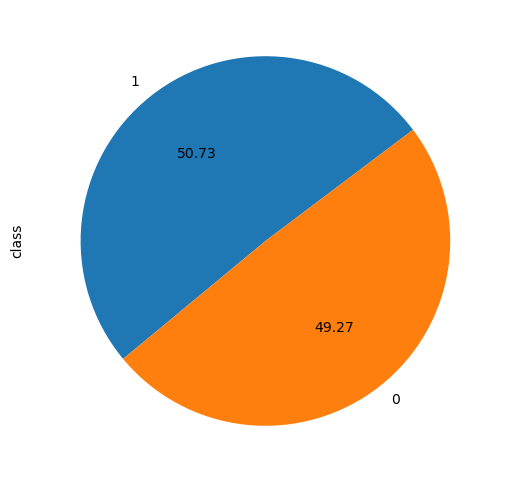

In [11]:
df_train['class'].value_counts().plot.pie(subplots=True,  autopct='%.2f', startangle=37, figsize=(11, 6))

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181467 entries, 0 to 181466
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181467 non-null  int64 
 1   text    181467 non-null  object
 2   class   181467 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


#### Text preprocessing

In [13]:
class Text_Preprocessing:
    def __init__(self, text):
        Text_Preprocessing.text = text
        # Some chat words examples
        Text_Preprocessing.chat_words = {
            'FYI' : 'for your information',
            'LOL' : 'laugh out loud',
            'AFK' : 'away from keyboard',
            '4U'  : 'for you',
            'NY'  : 'New York',
            'тт'  : 'так точно',
            'ок'  : 'хорошо'
        }
    
    # Chat word treatment
    @classmethod
    def chat_words_conv(cls):
        new_text = []
        for word in cls.text.split():
            if word.upper() in cls.chat_words:
                new_text.append(cls.chat_words[word.upper()])
            else:
                new_text.append(word)

        cls.text =  ' '.join(new_text)
        return cls

    # Spelling Correction
    @classmethod
    def spelling_corr(cls):
        cls.text = TextBlob(cls.text).correct().string
        return cls
    
    # Removing URLs
    @classmethod
    def remove_url(cls):
        re_url = re.compile('https?://\S+|www\.\S+')
        cls.text = re_url.sub('', cls.text)
        return cls
    
    # Handling Emojis
    @classmethod
    def demojize_emoji(cls):
        cls.text = emoji.demojize(cls.text)
        return cls
    
    # Lowercasing
    @classmethod
    def convert_lowercase(cls):
        cls.text = cls.text.lower()
        return cls
    
    # Removing HTML Tags
    @classmethod
    def remove_html_tags(cls):
        re_html = re.compile('<.*?>')
        cls.text = re_html.sub(r'', cls.text)
        return cls
    
    # Removing digits
    @classmethod
    def remove_digits(cls):
        cls.text = ''.join(filter(lambda x: not x.isdigit(), cls.text))
        return cls
    
    # Stemming
    @classmethod
    def perform_stemming(cls):
        new_text = [ps().stem(word) for word in cls.text.split()]
        cls.text = ' '.join(new_text)
        return cls
    
    # MorphAnalyzer
    @classmethod
    def morph_analyzer(cls):
        cls.text = ' '.join([morph_analyz.parse(word)[0].normal_form for word in cls.text.split()])
        return cls
    
    # Removing Punctuations
    @classmethod
    def remove_punc(cls):
        cls.text = cls.text.translate(str.maketrans('', '', string.punctuation))
        return cls
    
    # Removing stop words
    @classmethod
    def remove_stopwords(cls):
        new_text = []
        for word in cls.text.split():
            if word in stopwords_russian:
                continue
            else:
                new_text.append(word)

        cls.text = ' '.join(new_text)
        return cls

In [14]:
def text_preprocess(text):
    return (Text_Preprocessing(text)
            .chat_words_conv()
            .remove_url()
            .demojize_emoji()
            .remove_html_tags()
            .remove_digits()
            .convert_lowercase()
            .spelling_corr()
            .remove_punc()
            .remove_stopwords()
            .perform_stemming()
            .morph_analyzer()).text

In [15]:
re_url = re.compile('https?://\S+|www\.\S+')
ABC = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

def text_preprocess_light(text):
    text = str(text)
    text = re_url.sub('', text)
    text = ''.join(c for c in text if c not in punkts)
    text = ''.join(filter(lambda x: not x.isdigit(), ''.join(c for c in text if c not in ABC)))
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub('не\s', 'не', text)
    text = text.lower()
    text = [morph_analyz.parse(word)[0].normal_form for word in text.split() if word not in stopwords_russian]
    return " ".join(text)

In [16]:
tqdm.pandas()
df_train['text'] = df_train['text'].progress_apply(text_preprocess_light)
df_val['text'] = df_val['text'].progress_apply(text_preprocess_light)
df_test['text'] = df_test['text'].progress_apply(text_preprocess_light)

100%|███████████████████████████████████████████████████████████████████████████| 22684/22684 [00:37<00:00, 608.02it/s]


In [17]:
df_train.to_csv(DATA_ROOT + 'train_preprocess.csv')
df_val.to_csv(DATA_ROOT + 'val_preprocess.csv')
df_test.to_csv(DATA_ROOT + 'test_preprocess.csv')

#### Tokenization of texts, compilation of a corpus of texts and a word frequency dictionary

In [18]:
train_corpus = ' '.join(df_train['text'])
train_corpus

'неуезжаааааааать нехотеть уезжать ребята девчата кино любовь завтра вотэтолюбовь ненавидеть пробка ретвит хотеться котлета покиевск запретный плод босапоп есбосой небояться мороз манчестер час играть недом жаба пришол остаться транспорт правда девчёнка писать транспорт эт нев счёт момент мальчик маньяк ражик гладить рука феликс неудачик поцарапать экран телефон хахаа запомниться надолго красава несомневаться мартовский путёвка дорожать глаз пара день оо прошлый месяц вообще небыть привет самый хороший друг извращенобольный фантазия придуответить придумать новый увеличение лимит бесплатный пополнение мнесделать карта оставить тожить лах завтра идти голова непрекращать болеть пойти температурка померия крайнекультурный друг разговор незнакомый человек кузов оцинковать незнать ой непиздить неработать отмена встряхивание австрия ждеееть последний формальность уладить паковать чемодан одноклассник психанулон плакать понимать сразу ставить парнит понять оуовать рада тебя продажа прогноз пог

In [19]:
tokens = word_tokenize(train_corpus)
tokens[:5]

['неуезжаааааааать', 'нехотеть', 'уезжать', 'ребята', 'девчата']

In [20]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [21]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)] # -1 for padding
len(tokens_filtered_top)

1999

In [22]:
tokens_filtered_top[:10]

['хотеть',
 'новый',
 'завтра',
 'мой',
 'вообще',
 'любить',
 'хороший',
 'день',
 'делать',
 'немочь']

In [23]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'хотеть': 1,
 'новый': 2,
 'завтра': 3,
 'мой': 4,
 'вообще': 5,
 'любить': 6,
 'хороший': 7,
 'день': 8,
 'делать': 9,
 'немочь': 10,
 'знать': 11,
 'смотреть': 12,
 'блин': 13,
 'самый': 14,
 'думать': 15,
 'идти': 16,
 'дом': 17,
 'спать': 18,
 'сидеть': 19,
 'друг': 20,
 'утро': 21,
 'один': 22,
 'небыть': 23,
 'школа': 24,
 'сделать': 25,
 'настроение': 26,
 'незнать': 27,
 'такой': 28,
 'человек': 29,
 'пойти': 30,
 'писать': 31,
 'ждать': 32,
 'час': 33,
 'мама': 34,
 'любимый': 35,
 'болеть': 36,
 'работа': 37,
 'последний': 38,
 'написать': 39,
 'никто': 40,
 'ночь': 41,
 'мочь': 42,
 'свой': 43,
 'посмотреть': 44,
 'нехотеть': 45,
 'добрый': 46,
 'говорить': 47,
 'чтоть': 48,
 'неделя': 49,
 'прийти': 50,
 'какой': 51,
 'купить': 52,
 'вчера': 53,
 'дело': 54,
 'скучать': 55,
 'найти': 56,
 'хотеться': 57,
 'урок': 58,
 'скоро': 59,
 'снег': 60,
 'фильм': 61,
 'голова': 62,
 'первый': 63,
 'видеть': 64,
 'остаться': 65,
 'оо': 66,
 'жить': 67,
 'понять': 68,
 'читать': 69,
 

#### Translation of texts in the max_len sequence

In [24]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text)
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in  tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0] * (maxlen - len(result))
    return result[-maxlen:] + padding

In [25]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train['text']])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val['text']])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test['text']])

Wall time: 28.1 s


In [26]:
df_train['text'].iloc[0]

'неуезжаааааааать нехотеть уезжать'

In [27]:
x_train[0]

array([ 45, 557,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

temp = 0
for i in range(len(x_train)):
    tmp = np.where(x_train[i] == 0)[0].min()
    if tmp > temp:
        temp = tmp
print(temp)

#### BidirectionalRNN, LSTM, GRU initialization

In [28]:
class BidirectionalRNNFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, use_last=True) :
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2, batch_first=True) # , bidirectional=True
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        
        rnn_out, ht = self.rnn(x)
        
        if self.use_last:
            last_tensor = rnn_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(rnn_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
    
        return torch.sigmoid(out)


class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)
    
    
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

#### Wrapper over data

In [29]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [30]:
train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [31]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 23])
torch.Size([512])
tensor(0)


####  BidirectionalRNN

In [32]:
bi_rnn_init = BidirectionalRNNFixedLen(max_words, 128, max_len, use_last=False)
optimizer = torch.optim.Adam(bi_rnn_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [33]:
print(bi_rnn_init)
print("Parameters:", sum([param.nelement() for param in bi_rnn_init.parameters()]))

BidirectionalRNNFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (rnn): RNN(128, 23, num_layers=2, batch_first=True)
  (linear): Linear(in_features=23, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 260647


In [34]:
bi_rnn_init = bi_rnn_init.to(device)
bi_rnn_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []
train_acc_history =[]
val_acc_history = []


for epoch in range(epochs):  
    bi_rnn_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = bi_rnn_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    bi_rnn_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    train_acc_history.append(running_right / running_items)
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = bi_rnn_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    val_acc_history.append(test_running_right / test_running_total)
        
print('Training is finished!')

Epoch [1/10]. Step [355/355]. Loss: 0.629. Acc: 0.600. Test loss: 0.404. Test acc: 0.659
Epoch [2/10]. Step [355/355]. Loss: 0.583. Acc: 0.667. Test loss: 0.225. Test acc: 0.680
Epoch [3/10]. Step [355/355]. Loss: 0.603. Acc: 0.681. Test loss: 0.701. Test acc: 0.686
Epoch [4/10]. Step [355/355]. Loss: 0.628. Acc: 0.685. Test loss: 0.529. Test acc: 0.686
Epoch [5/10]. Step [355/355]. Loss: 0.514. Acc: 0.688. Test loss: 0.910. Test acc: 0.688
Epoch [6/10]. Step [355/355]. Loss: 0.574. Acc: 0.691. Test loss: 0.985. Test acc: 0.689
Epoch [7/10]. Step [355/355]. Loss: 0.509. Acc: 0.693. Test loss: 0.531. Test acc: 0.688
Epoch [8/10]. Step [355/355]. Loss: 0.573. Acc: 0.693. Test loss: 0.328. Test acc: 0.687
Epoch [9/10]. Step [355/355]. Loss: 0.597. Acc: 0.695. Test loss: 0.243. Test acc: 0.690
Epoch [10/10]. Step [355/355]. Loss: 0.570. Acc: 0.697. Test loss: 0.324. Test acc: 0.691
Training is finished!


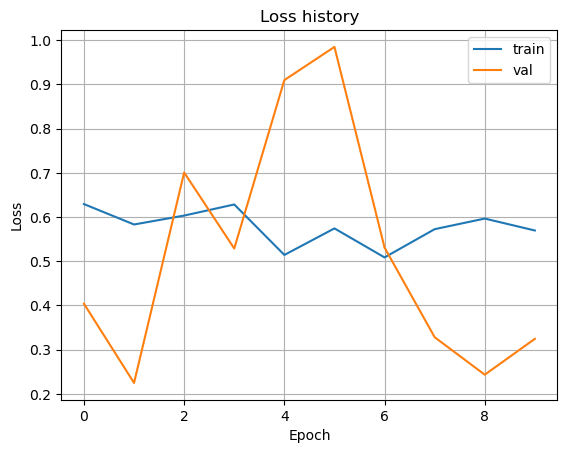

In [35]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='val')
plt.legend();

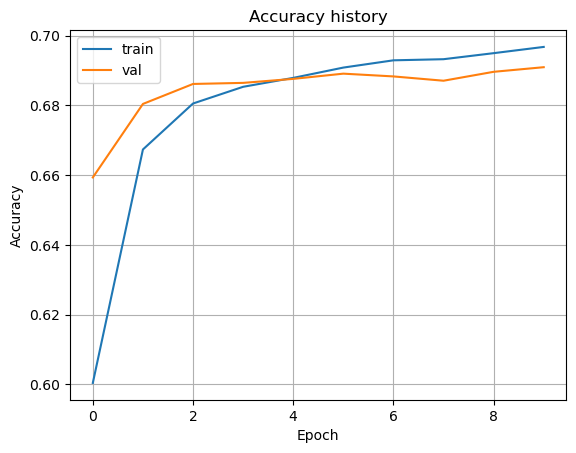

In [36]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(torch.stack(train_acc_history).cpu(), label='train')
plt.plot(torch.stack(val_acc_history).cpu(), label='val')
plt.legend();

#### LSTM

In [37]:
lstm_init = LSTMFixedLen(max_words, 128, max_len, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [38]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 23, num_layers=2, batch_first=True)
  (linear): Linear(in_features=23, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 274516


In [39]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []
train_acc_history =[]
val_acc_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    train_acc_history.append(running_right / running_items)
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
    val_acc_history.append(test_running_right / test_running_total)
        
print('Training is finished!')

Epoch [1/10]. Step [355/355]. Loss: 0.582. Acc: 0.615. Val loss: 0.226. Val acc: 0.674
Epoch [2/10]. Step [355/355]. Loss: 0.556. Acc: 0.676. Val loss: 1.014. Val acc: 0.685
Epoch [3/10]. Step [355/355]. Loss: 0.555. Acc: 0.688. Val loss: 1.332. Val acc: 0.683
Epoch [4/10]. Step [355/355]. Loss: 0.548. Acc: 0.691. Val loss: 0.883. Val acc: 0.689
Epoch [5/10]. Step [355/355]. Loss: 0.560. Acc: 0.694. Val loss: 0.441. Val acc: 0.690
Epoch [6/10]. Step [355/355]. Loss: 0.580. Acc: 0.696. Val loss: 0.490. Val acc: 0.689
Epoch [7/10]. Step [355/355]. Loss: 0.570. Acc: 0.699. Val loss: 0.590. Val acc: 0.689
Epoch [8/10]. Step [355/355]. Loss: 0.555. Acc: 0.701. Val loss: 0.310. Val acc: 0.690
Epoch [9/10]. Step [355/355]. Loss: 0.536. Acc: 0.702. Val loss: 1.437. Val acc: 0.690
Epoch [10/10]. Step [355/355]. Loss: 0.569. Acc: 0.703. Val loss: 0.527. Val acc: 0.689
Training is finished!


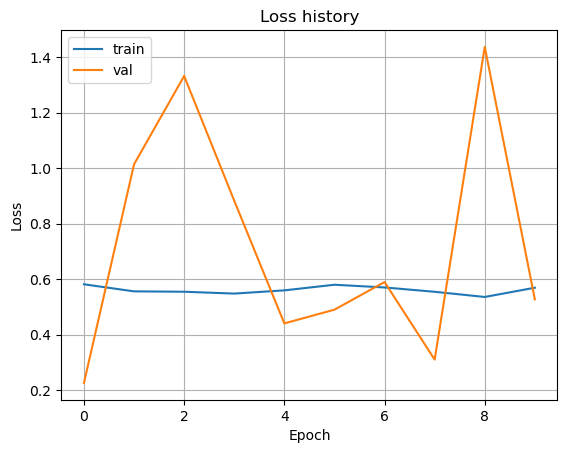

In [40]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='val')
plt.legend();

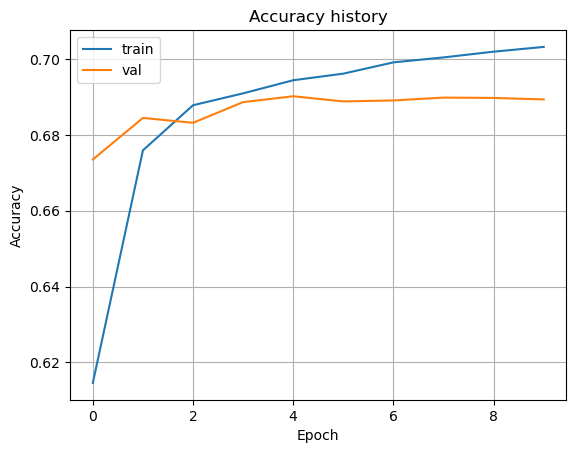

In [41]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(torch.stack(train_acc_history).cpu(), label='train')
plt.plot(torch.stack(val_acc_history).cpu(), label='val')
plt.legend();

#### GRU

In [42]:
gru_init = GRUFixedLen(max_words, 128, max_len, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [43]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 23, num_layers=2, batch_first=True)
  (linear): Linear(in_features=23, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 269893


In [44]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []
train_acc_history =[]
val_acc_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    train_acc_history.append(running_right / running_items)
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    val_acc_history.append(test_running_right / test_running_total)
            
print('Training is finished!')

Epoch [1/10]. Step [355/355]. Loss: 0.589. Acc: 0.623. Test loss: 0.587. Test acc: 0.678
Epoch [2/10]. Step [355/355]. Loss: 0.609. Acc: 0.676. Test loss: 0.367. Test acc: 0.688
Epoch [3/10]. Step [355/355]. Loss: 0.557. Acc: 0.684. Test loss: 0.303. Test acc: 0.690
Epoch [4/10]. Step [355/355]. Loss: 0.548. Acc: 0.690. Test loss: 0.747. Test acc: 0.689
Epoch [5/10]. Step [355/355]. Loss: 0.606. Acc: 0.693. Test loss: 0.407. Test acc: 0.692
Epoch [6/10]. Step [355/355]. Loss: 0.532. Acc: 0.695. Test loss: 0.414. Test acc: 0.692
Epoch [7/10]. Step [355/355]. Loss: 0.547. Acc: 0.696. Test loss: 0.899. Test acc: 0.691
Epoch [8/10]. Step [355/355]. Loss: 0.544. Acc: 0.699. Test loss: 0.967. Test acc: 0.691
Epoch [9/10]. Step [355/355]. Loss: 0.552. Acc: 0.699. Test loss: 0.240. Test acc: 0.690
Epoch [10/10]. Step [355/355]. Loss: 0.577. Acc: 0.701. Test loss: 0.871. Test acc: 0.692
Training is finished!


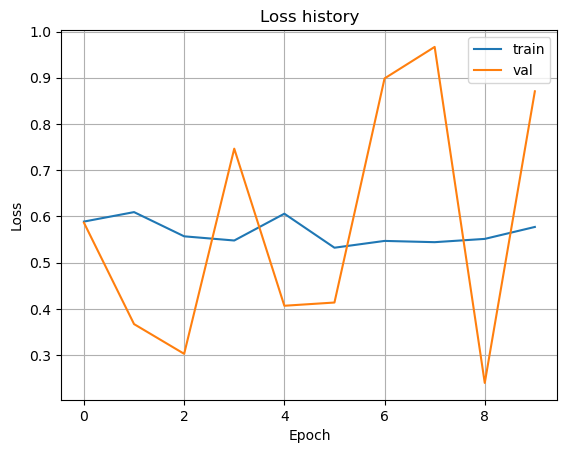

In [45]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='val')
plt.legend();

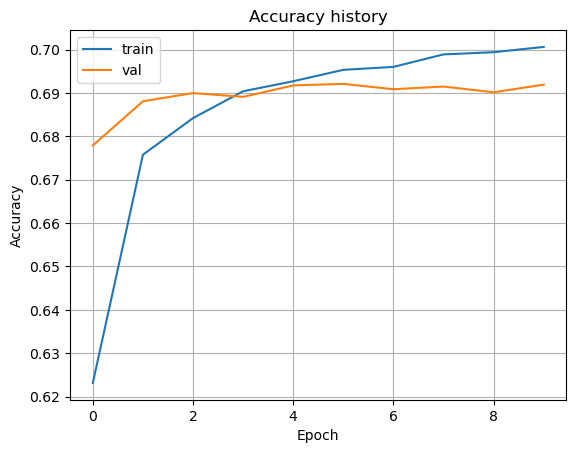

In [46]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(torch.stack(train_acc_history).cpu(), label='train')
plt.plot(torch.stack(val_acc_history).cpu(), label='val')
plt.legend();

#### Applying the trained model to test data

##### Best model is multi-layer gated recurrent unit (GRU)

In [61]:
torch.save(gru_init, DATA_ROOT + 'best_recurrent_model_tweet.pt')
model = torch.load(DATA_ROOT + 'best_recurrent_model_tweet.pt')

In [62]:
df_test

id                                               text
0      204150          тектоника рельефсамый ужасный мир мучение
1      204151     ходить запускать шар желание неполучиться хрен
2      204152        хотеть лето ради направить ноготь яркий лак
3      204153  блин шипперила флораблум музатекно стелла непо...
4      204154  блинкаждый воскресение утром выходить какашкап...
...       ...                                                ...
22679  226829                      небоскрёб небоскрёб маленький
22680  226830   школа новый человек спросить порядок чёрный люба
22681  226831                          привеееть муд черта сэмми
22682  226832       настроение вроде нормальный плакать хотеться
22683  226833  зайти сон девчонкампока мыть посудунастя фотка...

[22684 rows x 2 columns]

In [63]:
df_test['text'].iloc[0]

'тектоника рельефсамый ужасный мир мучение'

In [64]:
x_test[0]

tensor([282, 178,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], device='cuda:0',
       dtype=torch.int32)

In [65]:
x_test = x_test.to(device)

In [66]:
test_outputs = model(x_test)

In [67]:
pred_test_labels = torch.squeeze((test_outputs > th).int()).detach().cpu().numpy()

In [68]:
pred_test_labels

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
df_test['pred_class'] = pred_test_labels

In [70]:
df_test

id                                               text  pred_class
0      204150          тектоника рельефсамый ужасный мир мучение           0
1      204151     ходить запускать шар желание неполучиться хрен           0
2      204152        хотеть лето ради направить ноготь яркий лак           0
3      204153  блин шипперила флораблум музатекно стелла непо...           1
4      204154  блинкаждый воскресение утром выходить какашкап...           0
...       ...                                                ...         ...
22679  226829                      небоскрёб небоскрёб маленький           1
22680  226830   школа новый человек спросить порядок чёрный люба           1
22681  226831                          привеееть муд черта сэмми           0
22682  226832       настроение вроде нормальный плакать хотеться           0
22683  226833  зайти сон девчонкампока мыть посудунастя фотка...           0

[22684 rows x 3 columns]

array([<AxesSubplot:ylabel='pred_class'>], dtype=object)

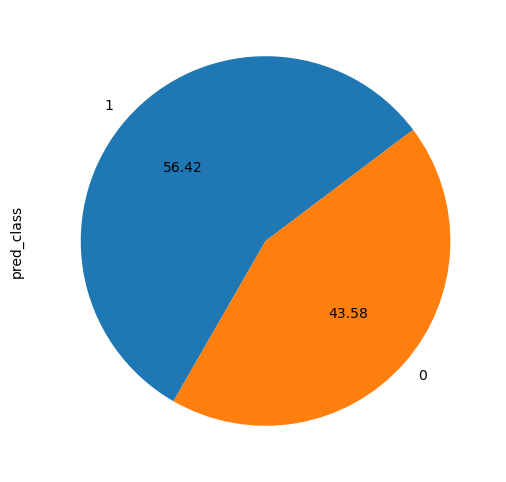

In [71]:
df_test['pred_class'].value_counts().plot.pie(subplots=True,  autopct='%.2f', startangle=37, figsize=(11, 6))